In [6]:
import numpy as np
import pcs as pcs
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import least_squares
from nepc import nepc
from nepc.methods.mp import mp as mp
from nepc.methods.thomson import thomson as thomson
from nepc.util.constants import N2_DIATOMIC_CONSTANTS
from nepc.util.constants import MU_NITROGEN_KG
from nepc.util.constants import WAVENUMBER_PER_EV as WAVENUMBER_PER_EV
from numpy import exp

# Shemansky

In [71]:
import csv
SHEMANSKY = []
with open('shemansky.csv', newline='') as csvfile:
    data = csv.reader(csvfile, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
    for row in data:
        SHEMANSKY.append(row)

for i in np.arange(55, 67):
    SHEMANSKY[i].insert(1, 0.0)        

INCIDENT_ENERGY_SHE = []
SHEMANSKY_OBS = []
SHEMANSKY_MODEL = []
SHEMANSKY_XX = []
SHEMANSKY_XA =[]
SHEMANSKY_XB = []

for i in np.arange(67):
    INCIDENT_ENERGY_SHE.append(SHEMANSKY[i][0])
    SHEMANSKY_OBS.append(SHEMANSKY[i][1])
    SHEMANSKY_MODEL.append(SHEMANSKY[i][2])
    SHEMANSKY_XX.append(SHEMANSKY[i][3])
    SHEMANSKY_XA.append(SHEMANSKY[i][4])
    SHEMANSKY_XB.append(SHEMANSKY[i][5])
INCIDENT_ENERGY_SHE = np.asarray(INCIDENT_ENERGY_SHE)
SHEMANSKY_OBS = np.asarray(SHEMANSKY_OBS)/100
SHEMANSKY_MODEL = np.asarray(SHEMANSKY_MODEL)/100
SHEMANSKY_XX = np.asarray(SHEMANSKY_XX)/100
SHEMANSKY_XA = np.asarray(SHEMANSKY_XA)/100
SHEMANSKY_XB = np.asarray(SHEMANSKY_XB)/100

In [69]:
SHEMANSKY

[[16.5, 4.66, 2.55, 2.55, 0.0, 0.0],
 [17.0, 7.13, 4.92, 4.17, 0.76, 0.0],
 [17.5, 9.85, 9.06, 5.89, 3.16, 0.0],
 [18.0, 12.9, 13.33, 7.71, 5.62, 0.0],
 [18.5, 16.4, 17.22, 9.6, 7.63, 0.0],
 [19.0, 19.9, 20.93, 11.54, 9.23, 0.16],
 [19.5, 23.0, 24.6, 13.51, 10.57, 0.53],
 [20.0, 27.0, 28.13, 15.51, 11.71, 0.91],
 [20.5, 30.8, 31.57, 17.52, 12.75, 1.3],
 [21.0, 34.4, 34.95, 19.53, 13.71, 1.7],
 [21.5, 38.0, 38.3, 21.53, 14.65, 2.12],
 [22.0, 41.8, 41.64, 23.52, 15.58, 2.55],
 [22.5, 45.5, 44.98, 25.48, 16.52, 2.98],
 [23.0, 49.2, 48.31, 27.41, 17.48, 3.42],
 [23.5, 52.8, 51.64, 29.31, 18.47, 3.87],
 [24.0, 56.5, 54.97, 31.17, 19.48, 4.32],
 [30.0, 92.9, 92.66, 49.78, 33.26, 9.61],
 [35.0, 116.0, 117.93, 60.12, 44.52, 13.28],
 [40.0, 137.0, 136.81, 66.83, 53.88, 16.1],
 [45.0, 152.0, 150.38, 71.06, 61.15, 18.18],
 [50.0, 160.0, 160.0, 73.68, 66.65, 19.67],
 [55.0, 166.0, 166.82, 75.3, 70.77, 20.75],
 [60.0, 172.0, 171.69, 76.3, 73.88, 21.51],
 [65.0, 174.0, 175.21, 76.93, 76.23, 22.06],


In [72]:
INCIDENT_ENERGY_SHE

array([   16.5,    17. ,    17.5,    18. ,    18.5,    19. ,    19.5,
          20. ,    20.5,    21. ,    21.5,    22. ,    22.5,    23. ,
          23.5,    24. ,    30. ,    35. ,    40. ,    45. ,    50. ,
          55. ,    60. ,    65. ,    70. ,    75. ,    80. ,    85. ,
          90. ,    95. ,   100. ,   110. ,   120. ,   140. ,   160. ,
         180. ,   200. ,   225. ,   250. ,   275. ,   300. ,   350. ,
         400. ,   450. ,   500. ,   550. ,   600. ,   650. ,   700. ,
         750. ,   800. ,   850. ,   900. ,   950. ,  1000. ,  1500. ,
        2000. ,  2500. ,  3000. ,  4000. ,  5000. ,  6000. ,  7000. ,
        8000. ,  9000. , 10000. , 15000. ])

# Plot psi_v, v=10

In [43]:
N2_DIATOMIC_CONSTANTS.keys()

dict_keys(['N2(X1Sigmag+)', 'N2(A3Sigmau+)', 'N2(B3Pig)', 'N2(W3Deltau)', 'N2(Bp3Sigmau-)', 'N2(ap1Sigmau-)', 'N2(a1Pig)', 'N2(w1Deltau)', 'N2(C3Piu)', 'N2+(X2Sigmag+)', 'N2+(A2Piu)', 'N2+(B2Sigmau+)', 'N2+(C2Sigmau+)'])

# Compute Overlap Matrix and Check for Identity

In [44]:
overlap_X = thomson.fcf_v(vp_max=10, vpp_max=10,
                          diatomic_constants_p=N2_DIATOMIC_CONSTANTS['N2(X1Sigmag+)'],
                          diatomic_constants_pp=N2_DIATOMIC_CONSTANTS['N2(X1Sigmag+)'],
                          reduced_mass=MU_NITROGEN_KG,
                          k=17,
                          delta_r=.5,
                          dbug=False)

In [45]:
thomson.rmse_diagonal_elements(np.asarray(overlap_X))

4.115206214252541e-07

In [46]:
thomson.incremental_rmse_diagonal_elements(np.asarray(overlap_X))

i: 1; rmse: 1.2434497875801753e-14
i: 2; rmse: 5.844456963317449e-14
i: 3; rmse: 8.705960933385516e-14
i: 4; rmse: 1.3228087202133447e-13
i: 5; rmse: 8.628411822787013e-12
i: 6; rmse: 2.0702115185528743e-11
i: 7; rmse: 7.328597843980401e-10
i: 8; rmse: 2.784505527958912e-09
i: 9; rmse: 4.102019172911683e-08
i: 10; rmse: 2.1819391570116893e-07
i: 11; rmse: 4.115206214252541e-07


In [47]:
thomson.rmse_off_diagonal_elements(np.asarray(overlap_X))

6.141937313299019e-09

In [48]:
thomson.incremental_rmse_off_diagonal_elements(np.asarray(overlap_X))

i: 2; rmse: 2.074522339725268e-25
i: 3; rmse: 7.19577869861297e-24
i: 4; rmse: 1.4098660106951825e-21
i: 5; rmse: 5.293939028789621e-20
i: 6; rmse: 1.3997629509065152e-17
i: 7; rmse: 1.251273893768826e-15
i: 8; rmse: 3.987297853306026e-15
i: 9; rmse: 2.0832045321553765e-13
i: 10; rmse: 5.172114071122606e-11
i: 11; rmse: 6.141937313299019e-09


# Closure relationship for FCF
If the FCF sum over vpp for a given vp are greater than 0.99, that's were we'll stop including cross sections

In [49]:
p_list = ['N2(X1Sigmag+)']
pp_list = ['N2+(X2Sigmag+)', 'N2+(A2Piu)', 'N2+(B2Sigmau+)']
vp_list = [0]
fcf = []
"""fcf[pp][vp][vpp]"""
for pp in pp_list:
    for vp in vp_list:
        fcf.append(thomson.fcf_v(vp_max=10, vpp_max=10,
                          diatomic_constants_p=N2_DIATOMIC_CONSTANTS['N2(X1Sigmag+)'],
                          diatomic_constants_pp=N2_DIATOMIC_CONSTANTS[pp],
                          reduced_mass=MU_NITROGEN_KG,
                          k=17,
                          delta_r=.5,
                          dbug=False))

# Total cross section data from literature

In [107]:
INCIDENT_ENERGY = [16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 19.0, 19.5, 20.0, 20.5, 21.0, 21.5, 22.0, 22.5, 23.0, 23.5, 24.0, 24.5, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0, 110.0, 120.0, 140.0, 160.0, 180.0, 200.0, 225.0, 250.0, 275.0, 300.0, 350.0, 400.0, 450.0, 500.0, 550.0, 600.0, 650.0, 700.0, 750.0, 800.0, 850.0, 900.0, 950.0, 1000.0]
ITIKAWA = np.asarray([0.0211, 0.0466, 0.0713, 0.0985, 0.129, 0.164, 0.199, 0.23, 0.27, 0.308, 0.344, 0.38, 0.418, 0.455, 0.492, 0.528, 0.565, 0.603, 0.64, 0.929, 1.16, 1.37, 1.52, 1.6, 1.66, 1.72, 1.74, 1.78, 1.8, 1.81, 1.82, 1.83, 1.85, 1.85, 1.83, 1.81, 1.78, 1.72, 1.67, 1.61, 1.55, 1.48, 1.41, 1.37, 1.28, 1.2, 1.11, 1.05, 0.998, 0.943, 0.88, 0.844, 0.796, 0.765, 0.738, 0.719, 0.698, 0.676])

# Function to compute partial cross section data array

In [51]:
def compute_pcs_array(a, b, c):
    ee_pcs = []
    for pp in np.arange(3):
        for vp in np.arange(1):
            for vpp in np.arange(max_vpp[pp]+1):
                pcs_data = pcs.pcs(p_state=p_list[0], pp_state=pp_list[pp], 
                               vp=vp, vpp=vpp, fcf=fcf[pp][vp][vpp],
                               a=a[pp+vpp], b=b, c=c)
                sigmas = []
                for i in range(len(pcs_data)):
                    sigmas.append(pcs_data[i][1])
                ee_pcs.append(sigmas)
    return ee_pcs

# Initial guess for universal function parameters

In [52]:
a=np.zeros(10)+2.5626 #2.6
b=11.7463 #9.2
c=1.0089 #2.4

In [53]:
max_vpp = [1,5,1]

In [54]:
ee_pcs = np.asarray(compute_pcs_array(a, b, c))

In [55]:
def find_ufc(Coefficients):
    """computes the SSR for the total cross section compared to Itikawa's. 
    Then using minimize to find the coefficients that produce the smallest SSR"""
    N, B, C = Coefficients
    ee_pcs = []
    for pp in np.arange(3):
        for vp in np.arange(1):
            for vpp in np.arange(max_vpp[pp]+1):
                pcs_data = pcs.pcs(p_state=p_list[0], pp_state=pp_list[pp], 
                               vp=vp, vpp=vpp, fcf=fcf[pp][vp][vpp],
                               a=N, b=B, c=C)
                sigmas = []
                for i in range(len(pcs_data)):
                    sigmas.append(pcs_data[i][1])
                ee_pcs.append(sigmas)
    ee_pcs = np.asarray(ee_pcs)
    total_pcs = np.zeros(58)
    for i in ee_pcs:
        total_pcs += i
    
    diff_sq = (ITIKAWA - (total_pcs*1.0E20))**2
    sum_diff = np.sum(diff_sq)
    
    return sum_diff

In [91]:
find_ufc([2.56261423, 11.74626331,  1.00890865])

0.04783390527319328

In [57]:
x0 = np.asarray([2.6, 9.2, 3.0])
res =  minimize(find_ufc, x0, method='nelder-mead', options={'xtol': 1e-8, 'disp':True})
print(res)

Optimization terminated successfully.
         Current function value: 0.047834
         Iterations: 209
         Function evaluations: 377
 final_simplex: (array([[ 2.56261423, 11.74626331,  1.00890865],
       [ 2.56261423, 11.74626331,  1.00890865],
       [ 2.56261423, 11.74626332,  1.00890865],
       [ 2.56261423, 11.7462633 ,  1.00890865]]), array([0.04783391, 0.04783391, 0.04783391, 0.04783391]))
           fun: 0.04783390527319322
       message: 'Optimization terminated successfully.'
          nfev: 377
           nit: 209
        status: 0
       success: True
             x: array([ 2.56261423, 11.74626331,  1.00890865])


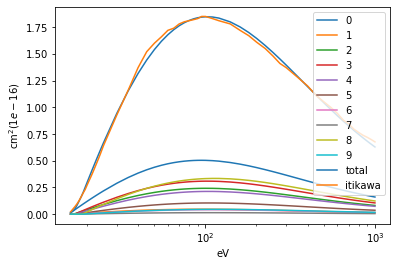

In [59]:
fig1, ax1 = plt.subplots(1)
for i in range(len(ee_pcs)):
    ax1.plot(INCIDENT_ENERGY, ee_pcs[i]*1.0E20, label='{}'.format(i))
ax1.plot(INCIDENT_ENERGY, np.sum(ee_pcs*1.0E20, axis=0), label='total')
ax1.plot(INCIDENT_ENERGY, ITIKAWA, label='itikawa')
ax1.set_xscale('log')
ax1.set_ylabel('cm$^2 (1e-16)$')
ax1.set_xlabel('eV')
ax1.legend()
plt.show()

# Figures and Tables

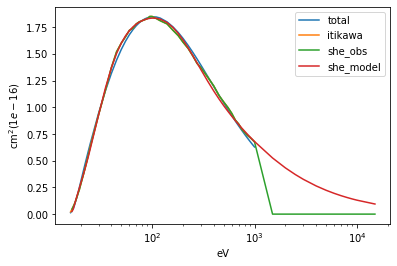

In [75]:
fig2, ax2 = plt.subplots(1)
ax2.plot(INCIDENT_ENERGY, np.sum(ee_pcs*1.0E20, axis=0), label='total')
ax2.plot(INCIDENT_ENERGY, ITIKAWA, label='itikawa')
ax2.plot(INCIDENT_ENERGY_SHE, SHEMANSKY_OBS, label='she_obs')
ax2.plot(INCIDENT_ENERGY_SHE, SHEMANSKY_MODEL, label='she_model')
ax2.set_xscale('log')
ax2.set_ylabel('cm$^2 (1e-16)$')
ax2.set_xlabel('eV')
ax2.legend()
plt.show()

## N2 X1Sigmag+ to N2+ X2Sigmag+

In [143]:
def find_ufc_XX(Coefficients):
    """computes the SSR for the total cross section compared to Itikawa's. 
    Then using minimize to find the coefficients that produce the smallest SSR"""
    N, B, C = Coefficients
    ee_pcs = []
    for pp in np.arange(1):
        for vp in np.arange(1):
            for vpp in np.arange(2):
                pcs_data = pcs.pcs(p_state=p_list[0], pp_state=pp_list[pp], 
                               vp=vp, vpp=vpp, fcf=fcf[pp][vp][vpp],
                               a=N, b=B, c=C)
                sigmas = []
                for i in range(len(pcs_data)):
                    sigmas.append(pcs_data[i][1])
                ee_pcs.append(sigmas)
    
    ee_pcs[0].pop(0)
    ee_pcs[0].pop(16)
    ee_pcs[0].pop(16)
    ee_pcs[1].pop(0)
    ee_pcs[1].pop(16)
    ee_pcs[1].pop(16)
    ee_pcs = np.asarray(ee_pcs)
    total_pcs = np.zeros(55)
    for i in ee_pcs:
        total_pcs += i
    
    SHEMANSKY_XX_55 = []
    INCIDENT_ENERGY_SHE_55 = []
    for i in np.arange(55):
        SHEMANSKY_XX_55.append(SHEMANSKY_XX[i])
        INCIDENT_ENERGY_SHE_55.append(INCIDENT_ENERGY_SHE[i])
    
    SHEMANSKY_XX_55 = np.asarray(SHEMANSKY_XX_55)
    
    diff_sq = (SHEMANSKY_XX_55 - (total_pcs*1.0E20))**2
    sum_diff = np.sum(diff_sq)
    
    return sum_diff

In [145]:
ee_pcs_XX = []
N, B, C = [4.48610974, 16.53230571,  0.67914942]
for pp in np.arange(1):
    for vp in np.arange(1):
        for vpp in np.arange(2):
            pcs_data = pcs.pcs(p_state=p_list[0], pp_state=pp_list[pp], 
                               vp=vp, vpp=vpp, fcf=fcf[pp][vp][vpp],
                               a=N, b=B, c=C)
            sigmas = []
            for i in range(len(pcs_data)):
                sigmas.append(pcs_data[i][1])
            ee_pcs_XX.append(sigmas)
            
ee_pcs_XX[0].pop(0)
ee_pcs_XX[0].pop(16)
ee_pcs_XX[0].pop(16)
ee_pcs_XX[1].pop(0)
ee_pcs_XX[1].pop(16)
ee_pcs_XX[1].pop(16)
ee_pcs_XX = np.asarray(ee_pcs_XX)
total_pcs_XX = np.zeros(55)
for i in ee_pcs_XX:
    total_pcs_XX += i

SHEMANSKY_XX_55 = []
INCIDENT_ENERGY_SHE_55 = []
for i in np.arange(55):
    SHEMANSKY_XX_55.append(SHEMANSKY_XX[i])
    INCIDENT_ENERGY_SHE_55.append(INCIDENT_ENERGY_SHE[i])
    
SHEMANSKY_XX_55 = np.asarray(SHEMANSKY_XX_55)

INCIDENT_ENERGY_55 = []
for i in INCIDENT_ENERGY:
    INCIDENT_ENERGY_55.append(i)
INCIDENT_ENERGY_55.pop(0)
INCIDENT_ENERGY_55.pop(16)
INCIDENT_ENERGY_55.pop(16)

diff_sq = (SHEMANSKY_XX_55 - (total_pcs_XX*1.0E20))**2
np.sum(diff_sq)

0.03812307702765247

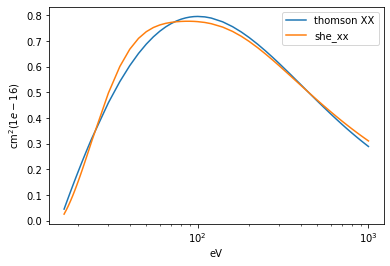

In [146]:
fig3, ax3 = plt.subplots(1)
ax3.plot(INCIDENT_ENERGY_55, (total_pcs_XX)*1.0E20, label='thomson XX')
ax3.plot(INCIDENT_ENERGY_SHE_55, SHEMANSKY_XX_55, label='she_xx')
ax3.set_xscale('log')
ax3.set_ylabel('cm$^2 (1e-16)$')
ax3.set_xlabel('eV')
ax3.legend()
plt.show()

In [144]:
find_ufc_XX([2.56261423, 11.74626331,  1.00890865])
x0 = np.asarray([2.56261423, 11.74626331,  1.00890865])
res =  minimize(find_ufc_XX, x0, method='nelder-mead', options={'xtol': 1e-8, 'disp':True})
print(res)

Optimization terminated successfully.
         Current function value: 0.038123
         Iterations: 124
         Function evaluations: 242
 final_simplex: (array([[ 4.48610974, 16.53230571,  0.67914942],
       [ 4.48610974, 16.53230571,  0.67914942],
       [ 4.48610974, 16.53230572,  0.67914942],
       [ 4.48610974, 16.53230572,  0.67914942]]), array([0.03812308, 0.03812308, 0.03812308, 0.03812308]))
           fun: 0.03812307702765245
       message: 'Optimization terminated successfully.'
          nfev: 242
           nit: 124
        status: 0
       success: True
             x: array([ 4.48610974, 16.53230571,  0.67914942])


## N2 X1Sigmag+ to N2+ A2Piu

In [154]:
def find_ufc_XA(Coefficients):
    """computes the SSR for the total cross section compared to Itikawa's. 
    Then using minimize to find the coefficients that produce the smallest SSR"""
    N, B, C = Coefficients
    ee_pcs = []
    for pp in np.arange(1,2):
        for vp in np.arange(1):
            for vpp in np.arange(6):
                pcs_data = pcs.pcs(p_state=p_list[0], pp_state=pp_list[pp], 
                               vp=vp, vpp=vpp, fcf=fcf[pp][vp][vpp],
                               a=N, b=B, c=C)
                sigmas = []
                for i in range(len(pcs_data)):
                    sigmas.append(pcs_data[i][1])
                ee_pcs.append(sigmas)
    for i in np.arange(6):
        ee_pcs[i].pop(0)
        ee_pcs[i].pop(16)
        ee_pcs[i].pop(16)
        ee_pcs = np.asarray(ee_pcs)
    total_pcs = np.zeros(55)
    for i in ee_pcs:
        total_pcs += i
    
    SHEMANSKY_XA_55 = []
    INCIDENT_ENERGY_SHE_55 = []
    for i in np.arange(55):
        SHEMANSKY_XA_55.append(SHEMANSKY_XA[i])
        INCIDENT_ENERGY_SHE_55.append(INCIDENT_ENERGY_SHE[i])
    
    SHEMANSKY_XA_55 = np.asarray(SHEMANSKY_XA_55)
    
    diff_sq = (SHEMANSKY_XA_55 - (total_pcs*1.0E20))**2
    sum_diff = np.sum(diff_sq)
    
    return sum_diff

In [156]:
ee_pcs_XA = []
N, B, C = [1.91631027, 4.19096724, 4.19096734]
for pp in np.arange(1,2):
    for vp in np.arange(1):
        for vpp in np.arange(6):
            pcs_data = pcs.pcs(p_state=p_list[0], pp_state=pp_list[pp], 
                               vp=vp, vpp=vpp, fcf=fcf[pp][vp][vpp],
                               a=N, b=B, c=C)
            sigmas = []
            for i in range(len(pcs_data)):
                sigmas.append(pcs_data[i][1])
            ee_pcs_XA.append(sigmas)

for i in np.arange(6):
    ee_pcs_XA[i].pop(0)
    ee_pcs_XA[i].pop(16)
    ee_pcs_XA[i].pop(16)

ee_pcs_XA = np.asarray(ee_pcs_XA)
total_pcs_XA = np.zeros(55)
for i in ee_pcs_XA:
    total_pcs_XA += i

SHEMANSKY_XA_55 = []
INCIDENT_ENERGY_SHE_55 = []
for i in np.arange(55):
    SHEMANSKY_XA_55.append(SHEMANSKY_XA[i])
    INCIDENT_ENERGY_SHE_55.append(INCIDENT_ENERGY_SHE[i])
    
SHEMANSKY_XA_55 = np.asarray(SHEMANSKY_XA_55)

INCIDENT_ENERGY_55 = []
for i in INCIDENT_ENERGY:
    INCIDENT_ENERGY_55.append(i)
INCIDENT_ENERGY_55.pop(0)
INCIDENT_ENERGY_55.pop(16)
INCIDENT_ENERGY_55.pop(16)

diff_sq = (SHEMANSKY_XA_55 - (total_pcs_XA*1.0E20))**2
np.sum(diff_sq)

0.015625901484710825

In [155]:
find_ufc_XA([2.56261423, 11.74626331,  1.00890865])
x0 = np.asarray([2.56261423, 11.74626331,  1.00890865])
res =  minimize(find_ufc_XA, x0, method='nelder-mead', options={'xtol': 1e-8, 'disp':True})
print(res)

Optimization terminated successfully.
         Current function value: 0.015626
         Iterations: 183
         Function evaluations: 340
 final_simplex: (array([[1.91631027, 4.19096724, 4.19096734],
       [1.91631027, 4.19096725, 4.19096733],
       [1.91631027, 4.19096723, 4.19096735],
       [1.91631027, 4.19096724, 4.19096734]]), array([0.0156259, 0.0156259, 0.0156259, 0.0156259]))
           fun: 0.015625901484710793
       message: 'Optimization terminated successfully.'
          nfev: 340
           nit: 183
        status: 0
       success: True
             x: array([1.91631027, 4.19096724, 4.19096734])


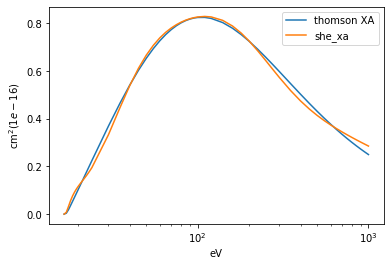

In [157]:
fig4, ax4 = plt.subplots(1)
ax4.plot(INCIDENT_ENERGY_55, (total_pcs_XA)*1.0E20, label='thomson XA')
ax4.plot(INCIDENT_ENERGY_SHE_55, SHEMANSKY_XA_55, label='she_xa')
ax4.set_xscale('log')
ax4.set_ylabel('cm$^2 (1e-16)$')
ax4.set_xlabel('eV')
ax4.legend()
plt.show()

## N2 X1Sigmag+ to N2+ B2Sigmau+

In [163]:
def find_ufc_XB(Coefficients):
    """computes the SSR for the total cross section compared to Itikawa's. 
    Then using minimize to find the coefficients that produce the smallest SSR"""
    N, B, C = Coefficients
    ee_pcs = []
    for pp in np.arange(2,3):
        for vp in np.arange(1):
            for vpp in np.arange(2):
                pcs_data = pcs.pcs(p_state=p_list[0], pp_state=pp_list[pp], 
                               vp=vp, vpp=vpp, fcf=fcf[pp][vp][vpp],
                               a=N, b=B, c=C)
                sigmas = []
                for i in range(len(pcs_data)):
                    sigmas.append(pcs_data[i][1])
                ee_pcs.append(sigmas)
    for i in np.arange(2):
        ee_pcs[i].pop(0)
        ee_pcs[i].pop(16)
        ee_pcs[i].pop(16)
        ee_pcs = np.asarray(ee_pcs)
    total_pcs = np.zeros(55)
    for i in ee_pcs:
        total_pcs += i
    
    SHEMANSKY_XB_55 = []
    INCIDENT_ENERGY_SHE_55 = []
    for i in np.arange(55):
        SHEMANSKY_XB_55.append(SHEMANSKY_XB[i])
        INCIDENT_ENERGY_SHE_55.append(INCIDENT_ENERGY_SHE[i])
    
    SHEMANSKY_XB_55 = np.asarray(SHEMANSKY_XB_55)
    
    diff_sq = (SHEMANSKY_XB_55 - (total_pcs*1.0E20))**2
    sum_diff = np.sum(diff_sq)
    
    return sum_diff

In [165]:
ee_pcs_XB = []
N, B, C = [1.36055036, 8.63427827, 1.27025972]
for pp in np.arange(2,3):
    for vp in np.arange(1):
        for vpp in np.arange(2):
            pcs_data = pcs.pcs(p_state=p_list[0], pp_state=pp_list[pp], 
                               vp=vp, vpp=vpp, fcf=fcf[pp][vp][vpp],
                               a=N, b=B, c=C)
            sigmas = []
            for i in range(len(pcs_data)):
                sigmas.append(pcs_data[i][1])
            ee_pcs_XB.append(sigmas)

for i in np.arange(2):
    ee_pcs_XB[i].pop(0)
    ee_pcs_XB[i].pop(16)
    ee_pcs_XB[i].pop(16)

ee_pcs_XB = np.asarray(ee_pcs_XB)
total_pcs_XB = np.zeros(55)
for i in ee_pcs_XB:
    total_pcs_XB += i

SHEMANSKY_XB_55 = []
INCIDENT_ENERGY_SHE_55 = []
for i in np.arange(55):
    SHEMANSKY_XB_55.append(SHEMANSKY_XB[i])
    INCIDENT_ENERGY_SHE_55.append(INCIDENT_ENERGY_SHE[i])
    
SHEMANSKY_XB_55 = np.asarray(SHEMANSKY_XB_55)

INCIDENT_ENERGY_55 = []
for i in INCIDENT_ENERGY:
    INCIDENT_ENERGY_55.append(i)
INCIDENT_ENERGY_55.pop(0)
INCIDENT_ENERGY_55.pop(16)
INCIDENT_ENERGY_55.pop(16)

diff_sq = (SHEMANSKY_XB_55 - (total_pcs_XB*1.0E20))**2
np.sum(diff_sq)

0.0016218340015292656

In [164]:
find_ufc_XB([2.56261423, 11.74626331,  1.00890865])
x0 = np.asarray([2.56261423, 11.74626331,  1.00890865])
res =  minimize(find_ufc_XB, x0, method='nelder-mead', options={'xtol': 1e-8, 'disp':True})
print(res)

Optimization terminated successfully.
         Current function value: 0.001622
         Iterations: 139
         Function evaluations: 275
 final_simplex: (array([[1.36055036, 8.63427827, 1.27025972],
       [1.36055036, 8.63427826, 1.27025973],
       [1.36055036, 8.63427826, 1.27025972],
       [1.36055036, 8.63427826, 1.27025973]]), array([0.00162183, 0.00162183, 0.00162183, 0.00162183]))
           fun: 0.0016218340015292597
       message: 'Optimization terminated successfully.'
          nfev: 275
           nit: 139
        status: 0
       success: True
             x: array([1.36055036, 8.63427827, 1.27025972])


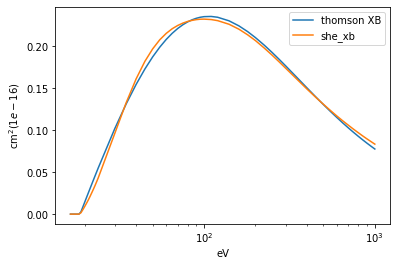

In [166]:
fig5, ax5 = plt.subplots(1)
ax5.plot(INCIDENT_ENERGY_55, (total_pcs_XB)*1.0E20, label='thomson XB')
ax5.plot(INCIDENT_ENERGY_SHE_55, SHEMANSKY_XB_55, label='she_xb')
ax5.set_xscale('log')
ax5.set_ylabel('cm$^2 (1e-16)$')
ax5.set_xlabel('eV')
ax5.legend()
plt.show()

# Comparing the totals for different f(x) for X,A,B

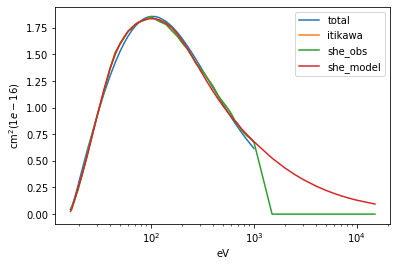

In [167]:
ITIKAWA_55 = []
for i in ITIKAWA:
    ITIKAWA_55.append(i)
ITIKAWA_55.pop(0)
ITIKAWA_55.pop(16)
ITIKAWA_55.pop(16)

fig6, ax6 = plt.subplots(1)
ax6.plot(INCIDENT_ENERGY_55, (total_pcs_XX+total_pcs_XA+total_pcs_XB)*1.0E20, label='total')
ax6.plot(INCIDENT_ENERGY_55, ITIKAWA_55, label='itikawa')
ax6.plot(INCIDENT_ENERGY_SHE, SHEMANSKY_OBS, label='she_obs')
ax6.plot(INCIDENT_ENERGY_SHE, SHEMANSKY_MODEL, label='she_model')
ax6.set_xscale('log')
ax6.set_ylabel('cm$^2 (1e-16)$')
ax6.set_xlabel('eV')
ax6.legend()
plt.show()